In [13]:
# Import libraries
# Penjelasan: Langkah pertama adalah mengimpor pustaka-pustaka yang diperlukan.
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import seaborn as sns

In [14]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
# Membuat dataset dummy untuk klasifikasi
# Dataset memiliki 1000 sampel, 20 fitur total, dan 2 kelas target
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_classes=2, random_state=42)

In [17]:
# Mengambil subset data (50%) untuk mempercepat eksperimen
subset_ratio = 0.5  # Proporsi data yang digunakan
indices = np.random.choice(len(X), int(len(X) * subset_ratio), replace=False)
X = X[indices]
y = y[indices]

In [18]:
# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# Konversi data ke format PyTorch tensor dan pindahkan ke GPU jika tersedia
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

In [20]:
# Fungsi untuk membuat DataLoader dengan batch size yang bervariasi
def create_dataloader(batch_size):
    # Dataset latih dan uji
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # DataLoader digunakan untuk mempermudah iterasi data dalam batch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [21]:
# Model Multilayer Perceptron (MLP)
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_neurons, activation_fn):
        super(MLPModel, self).__init__()
        layers = []  # Daftar layer dalam model
        current_size = input_size  # Dimensi input awal (20 fitur)

        # Membuat hidden layers sesuai parameter yang diberikan
        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_size, hidden_neurons))  # Layer fully connected
            # Tambahkan fungsi aktivasi sesuai parameter
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            current_size = hidden_neurons  # Dimensi output layer menjadi input untuk layer berikutnya

        # Output layer dengan 2 neuron (untuk 2 kelas)
        layers.append(nn.Linear(current_size, 2))
        self.model = nn.Sequential(*layers)  # Gabungkan semua layer dalam Sequential

    def forward(self, x):
        return self.model(x)  # Melakukan forward pass


In [22]:
# Early stopping untuk menghentikan pelatihan jika akurasi tidak meningkat
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience  # Berapa banyak epoch tanpa peningkatan sebelum berhenti
        self.delta = delta  # Perubahan minimal untuk dianggap peningkatan
        self.best_score = None  # Akurasi terbaik sejauh ini
        self.counter = 0  # Hitungan epoch tanpa peningkatan
        self.early_stop = False  # Apakah harus berhenti

    def __call__(self, accuracy):
        # Periksa apakah akurasi meningkat
        if self.best_score is None or accuracy > self.best_score + self.delta:
            self.best_score = accuracy
            self.counter = 0  # Reset counter jika ada peningkatan
        else:
            self.counter += 1
            if self.counter >= self.patience:  # Hentikan jika mencapai batas kesabaran
                self.early_stop = True


In [23]:
# Fungsi pelatihan model
def train_model(model, train_loader, criterion, optimizer, epochs, early_stopping=None):
    model.train()  # Mode training
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Hitung loss
            optimizer.zero_grad()  # Reset gradien
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameter

        # Periksa early stopping jika diaktifkan
        if early_stopping:
            accuracy = evaluate_model(model, train_loader)  # Hitung akurasi
            early_stopping(accuracy)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

In [24]:
# Fungsi evaluasi model
def evaluate_model(model, test_loader):
    model.eval()  # Mode evaluasi
    correct = 0  # Jumlah prediksi benar
    total = 0  # Total sampel
    with torch.no_grad():  # Nonaktifkan kalkulasi gradien
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Prediksi kelas dengan probabilitas tertinggi
            total += y_batch.size(0)  # Hitung total sampel
            correct += (predicted == y_batch).sum().item()  # Hitung prediksi benar
    return 100 * correct / total  # Akurasi dalam persen


In [25]:
# Eksperimen dengan berbagai kombinasi hyperparameter
hidden_layers_list = [1, 2]  # Variasi jumlah hidden layers
hidden_neurons_list = [4, 8]  # Variasi jumlah neuron per layer
activation_functions = ['relu', 'tanh']  # Variasi fungsi aktivasi
epochs_list = [10, 50]  # Variasi jumlah epoch
learning_rates = [0.01, 0.001]  # Variasi learning rate
batch_sizes = [128, 256]  # Variasi ukuran batch


In [26]:
# Menyimpan hasil eksperimen
results = []
for hidden_layers in hidden_layers_list:
    for hidden_neurons in hidden_neurons_list:
        for activation_fn in activation_functions:
            for epochs in epochs_list:
                for lr in learning_rates:
                    for batch_size in batch_sizes:
                        # Buat DataLoader dengan batch size yang berbeda
                        train_loader, test_loader = create_dataloader(batch_size)

                        # Inisialisasi model, loss function, dan optimizer
                        model = MLPModel(20, hidden_layers, hidden_neurons, activation_fn).to(device)
                        criterion = nn.CrossEntropyLoss()  # Loss untuk klasifikasi
                        optimizer = optim.AdamW(model.parameters(), lr=lr)  # Optimizer AdamW

                        # Early stopping
                        early_stopping = EarlyStopping(patience=3)
                        train_model(model, train_loader, criterion, optimizer, epochs, early_stopping)

                        # Evaluasi model
                        accuracy = evaluate_model(model, test_loader)
                        results.append({
                            'Hidden Layers': hidden_layers,
                            'Hidden Neurons': hidden_neurons,
                            'Activation': activation_fn,
                            'Epochs': epochs,
                            'Learning Rate': lr,
                            'Batch Size': batch_size,
                            'Accuracy': accuracy
                        })

Early stopping at epoch 4
Early stopping at epoch 34
Early stopping at epoch 21
Early stopping at epoch 4
Early stopping at epoch 14
Early stopping at epoch 12
Early stopping at epoch 45
Early stopping at epoch 10
Early stopping at epoch 44
Early stopping at epoch 46
Early stopping at epoch 46
Early stopping at epoch 7
Early stopping at epoch 5
Early stopping at epoch 43
Early stopping at epoch 45
Early stopping at epoch 40
Early stopping at epoch 4
Early stopping at epoch 4
Early stopping at epoch 4
Early stopping at epoch 25
Early stopping at epoch 30
Early stopping at epoch 4
Early stopping at epoch 4
Early stopping at epoch 10
Early stopping at epoch 4
Early stopping at epoch 21
Early stopping at epoch 17
Early stopping at epoch 46
Early stopping at epoch 4
Early stopping at epoch 30
Early stopping at epoch 33
Early stopping at epoch 28
Early stopping at epoch 9
Early stopping at epoch 33
Early stopping at epoch 16
Early stopping at epoch 4
Early stopping at epoch 43


In [27]:
# Konversi hasil ke DataFrame untuk analisis
results_df = pd.DataFrame(results)


In [28]:
# Tampilkan konfigurasi terbaik berdasarkan akurasi
results_df.sort_values(by="Accuracy", ascending=False).head(10)

,Hidden Layers,Hidden Neurons,Activation,Epochs,Learning Rate,Batch Size,Accuracy
21,1,8,relu,50,0.01,256,92.0
37,2,4,relu,50,0.01,256,89.0
53,2,8,relu,50,0.01,256,89.0
52,2,8,relu,50,0.01,128,89.0
60,2,8,tanh,50,0.01,128,88.0
4,1,4,relu,50,0.01,128,87.0
20,1,8,relu,50,0.01,128,87.0
48,2,8,relu,10,0.01,128,86.0
36,2,4,relu,50,0.01,128,86.0
29,1,8,tanh,50,0.01,256,86.0


In [29]:
# Visualize the top configurations by accuracy
# Penjelasan: Plot hasil akurasi berdasarkan berbagai kombinasi parameter.
top_results = results_df.sort_values(by="Accuracy", ascending=False).head(10)


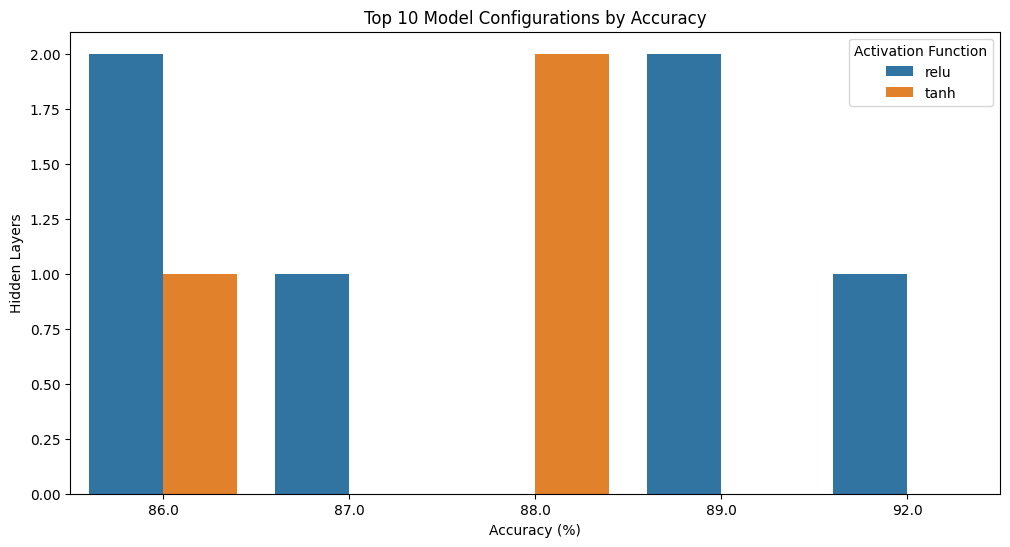

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_results, x="Accuracy", y="Hidden Layers", hue="Activation")
plt.title("Top 10 Model Configurations by Accuracy")
plt.xlabel("Accuracy (%)")
plt.ylabel("Hidden Layers")
plt.legend(title="Activation Function")
plt.show()

<ipython-input-31-fcdaf22f2679>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="Hidden Layers", y="Accuracy", palette="Set3")


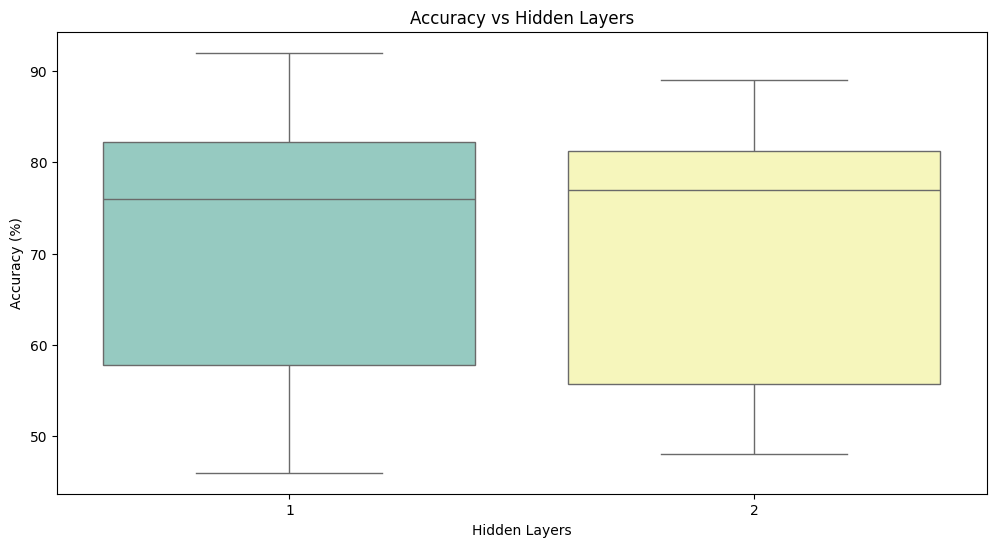

In [31]:
# Accuracy vs Hidden Layers
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x="Hidden Layers", y="Accuracy", palette="Set3")
plt.title("Accuracy vs Hidden Layers")
plt.xlabel("Hidden Layers")
plt.ylabel("Accuracy (%)")
plt.show()


<ipython-input-32-72c8919ab589>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="Hidden Neurons", y="Accuracy", palette="Set2")


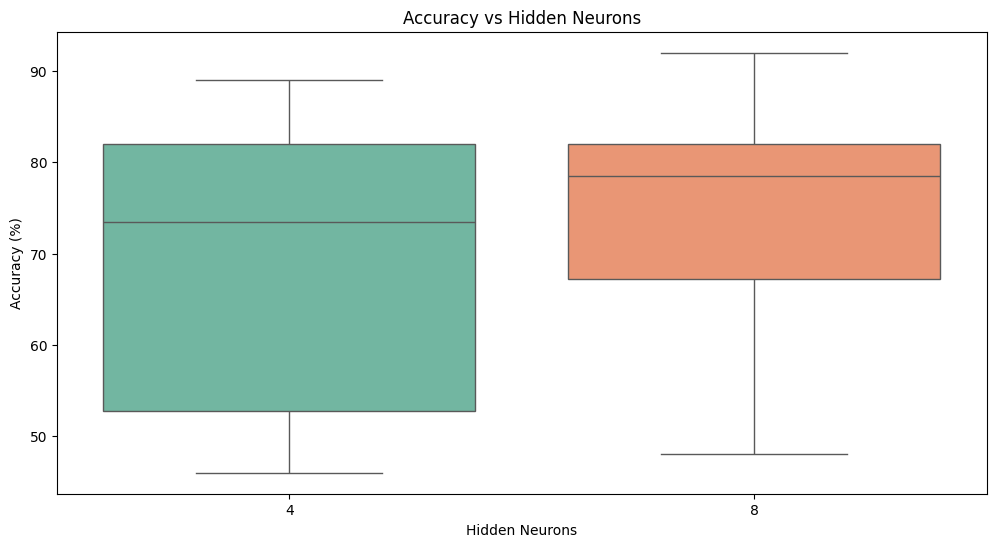

In [32]:
# Accuracy vs Neurons
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x="Hidden Neurons", y="Accuracy", palette="Set2")
plt.title("Accuracy vs Hidden Neurons")
plt.xlabel("Hidden Neurons")
plt.ylabel("Accuracy (%)")
plt.show()

<ipython-input-33-d3e73527eaa1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="Activation", y="Accuracy", palette="Set1")


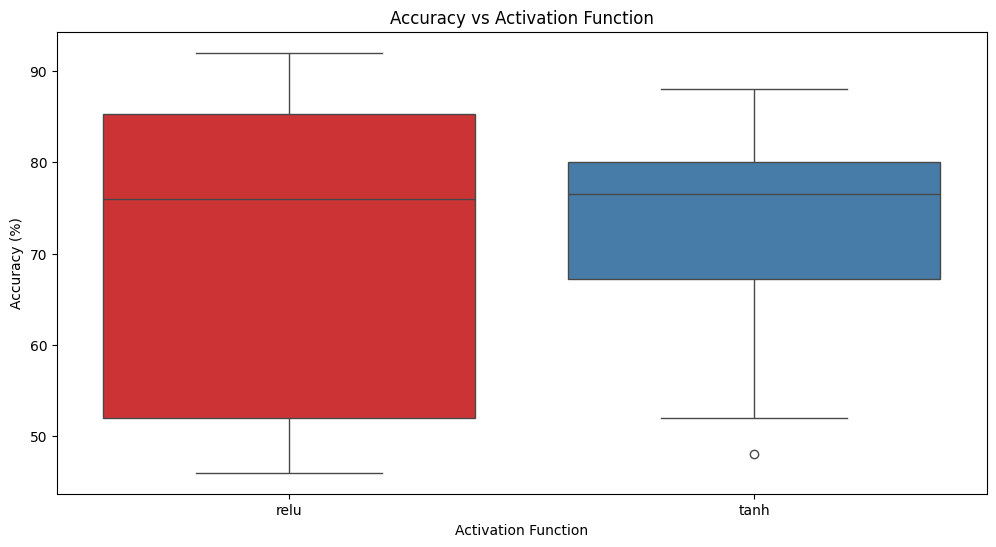

In [33]:
# Accuracy vs Activation Function
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x="Activation", y="Accuracy", palette="Set1")
plt.title("Accuracy vs Activation Function")
plt.xlabel("Activation Function")
plt.ylabel("Accuracy (%)")
plt.show()

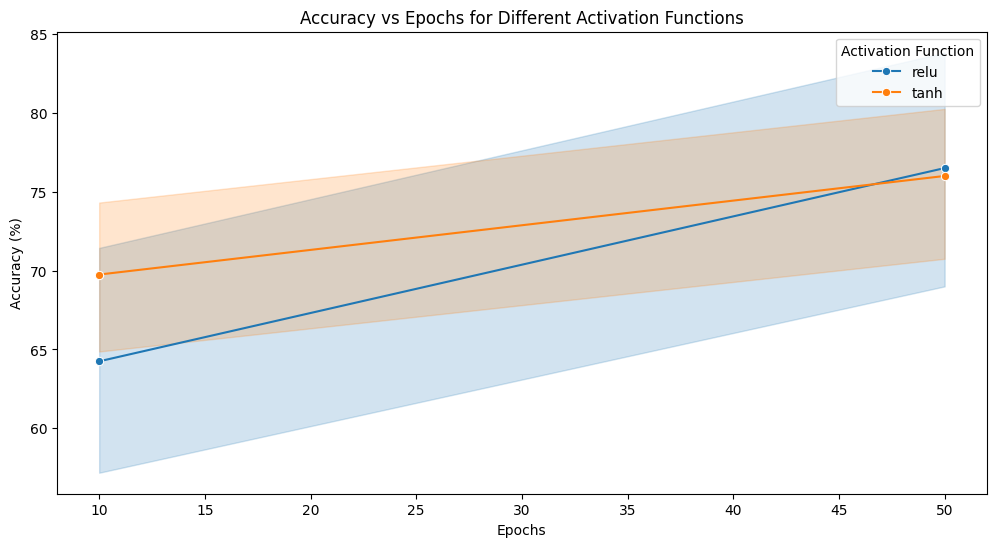

In [34]:

# Accuracy vs Epochs
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Epochs", y="Accuracy", hue="Activation", marker="o")
plt.title("Accuracy vs Epochs for Different Activation Functions")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(title="Activation Function")
plt.show()

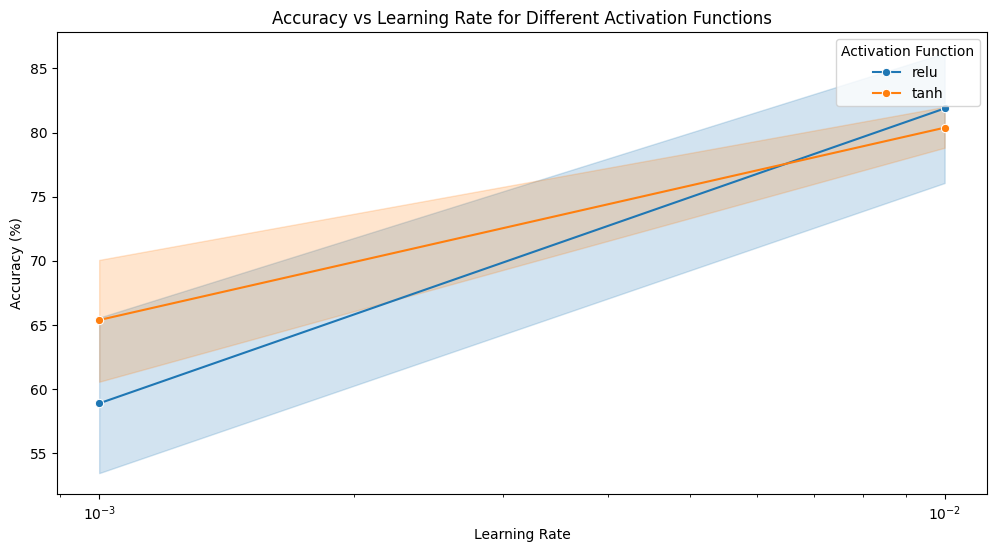

In [35]:
# Accuracy vs Learning Rate
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Learning Rate", y="Accuracy", hue="Activation", marker="o")
plt.title("Accuracy vs Learning Rate for Different Activation Functions")
plt.xscale("log")  # Log scale for learning rates
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.legend(title="Activation Function")
plt.show()


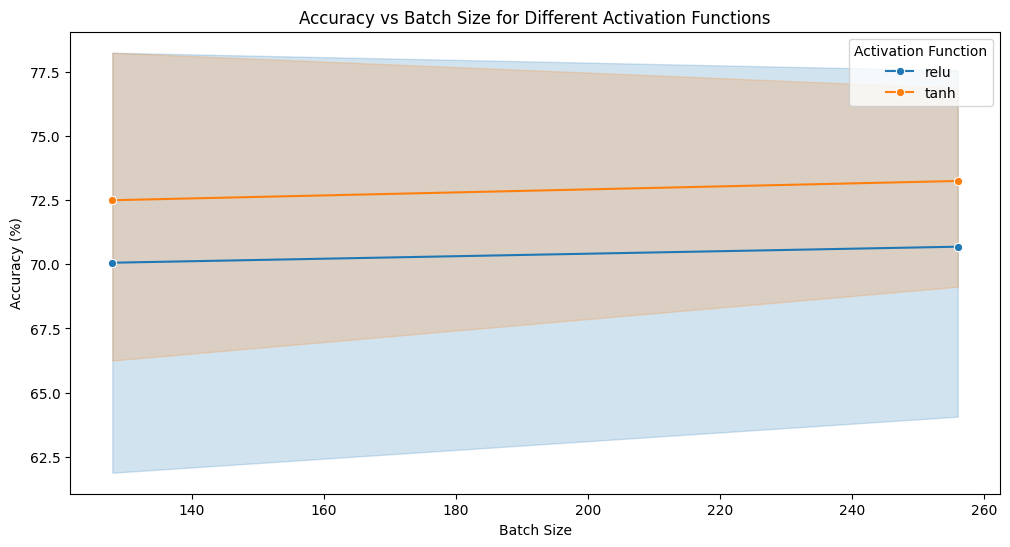

In [36]:
# Accuracy vs Batch Size
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Batch Size", y="Accuracy", hue="Activation", marker="o")
plt.title("Accuracy vs Batch Size for Different Activation Functions")
plt.xlabel("Batch Size")
plt.ylabel("Accuracy (%)")
plt.legend(title="Activation Function")
plt.show()
